## Preparing the dataset

In [1]:
import pandas as pd
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import xgboost as xgb

from collections import Counter

from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format','{:.5f}'.format)
np.set_printoptions(suppress=True)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim.downloader as api
from sklearn.manifold import TSNE
from adjustText import adjust_text
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.metrics.pairwise import cosine_similarity as cosine

from matplotlib import cm

import matplotlib.patches as mpatches

In [5]:
df_52 = pd.read_csv("./Beer52_beers.csv")
df_52

,review_overall,number_of_reviews,Name of beer,Brewery,Country,Style,ABV,°C,Hoppy,Malty,Sweet,Mouthfeel,Sour,Fruit,Floral,Bitter,Look,Aroma,Tasting notes
0,4.14000,132,Hopstravaganza,White Hag,Ireland,Hazy IPA,6.80000,5,5.00000,2.00000,3.00000,4.00000,1.00000,4.00000,2.00000,1.00000,"hazy, straw","fruity, tropical","Double IPA with exotic tasting notes, such as ..."
1,3.97000,110,Bullroarer,Round Corner,England,American pale ale,5.20000,6,4.00000,2.00000,1.00000,3.00000,0.00000,3.00000,3.00000,4.00000,"hazy, golden","citrusy, floral",Gentle malts underpin luscious aromas of citru...
2,3.96000,106,Totality,Siren,England,Session IPA,4.30000,6,4.00000,2.00000,2.00000,3.00000,0.00000,2.00000,2.00000,2.00000,"hazy, golden","tropical, citrusy","A crushable session IPA, features Eclipse hops..."
3,3.84000,138,Callista Pilsner,Garden,Croatia,Pilsner,5.00000,4.6,4.00000,1.00000,2.00000,2.00000,0.00000,3.00000,3.00000,2.00000,"clear, straw",fruity,"Super refreshing, dry-hopped Pilsner. Fermente..."
4,3.91000,46,Lucky,Trouble Brewing,Ireland,Pale ale,5.80000,4.6,4.00000,3.00000,3.00000,3.00000,0.00000,3.00000,3.00000,2.00000,"hazy, golden","citrusy, fruity",Lucky has a slight haziness and a full and bri...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,3.88000,221,Nitro Stout,Dundalk Bay,Ireland,Nitro sout,4.20000,6,0.50000,4.50000,3.50000,4.00000,0.00000,1.00000,0.50000,2.00000,black,"chocolate, coffee",Draught-like cascading effect on pour. Full-bo...
102,4.00000,211,Tundra Tropical IPA,Wicklow Wolf,Ireland,New England IPA,5.60000,8-10,5.00000,2.00000,3.00000,4.00000,0.00000,5.00000,1.00000,2.00000,"hazy, amber","citrusy, tropical",Dry hopped with a massive amount of tropical h...
103,3.12000,345,Spree Series Watermelon,The White Hag,Ireland,Watermelon IPA,5.50000,7-10,3.00000,1.00000,1.00000,2.00000,0.00000,3.00000,2.00000,3.00000,green,"watermelon, grapefruit",Pungent grapefruit and hints of watermelon. Gr...
104,3.66000,141,Irish White Ale,Heaney,Ireland,Witbier,4.80000,4,1.00000,2.00000,2.00000,3.00000,1.00000,3.00000,4.00000,2.00000,"hazy, straw","floral, citrusy",A classic Wit style brewed with coriander and ...


In [14]:
df_52 = pd.read_csv("./Beer52_beers.csv")
df_52=df_52[['Name of beer', 'Brewery', 'Style', 'ABV', 'Hoppy',
       'Malty', 'Sweet', 'Sour', 'Fruit', 'Bitter','Tasting notes','review_overall','number_of_reviews']]
df_52=df_52.rename(columns={'Name of beer':'Name','Tasting notes':'Description'})


df_52["Hoppy"] = MinMaxScaler().fit_transform(df_52['Hoppy'].values.reshape(-1, 1))
df_52["Malty"] = MinMaxScaler().fit_transform(df_52['Malty'].values.reshape(-1, 1))
df_52["Sweet"] = MinMaxScaler().fit_transform(df_52['Sweet'].values.reshape(-1, 1))
df_52["Sour"] = MinMaxScaler().fit_transform(df_52['Sour'].values.reshape(-1, 1))
df_52["Fruit"] = MinMaxScaler().fit_transform(df_52['Fruit'].values.reshape(-1, 1))
df_52["Bitter"] = MinMaxScaler().fit_transform(df_52['Bitter'].values.reshape(-1, 1))

In [13]:
df_BA = pd.read_csv("./beer_profile_and_ratings.csv")
df_BA

,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.30000,25,50,13,32,9,47,74,33,0,33,57,8,111,3.49899,3.63682,3.55634,3.64386,3.84708,497
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.20000,25,50,12,57,18,33,55,16,0,24,35,12,84,3.79834,3.84615,3.90437,4.02495,4.03430,481
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.00000,25,50,14,37,6,42,43,11,0,10,54,4,62,3.40981,3.66711,3.60080,3.63130,3.83024,377
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.50000,25,50,13,55,31,47,101,18,1,49,40,16,119,4.14810,4.03397,4.15081,4.20516,4.00544,368
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.20000,25,50,25,51,26,44,45,9,1,11,51,20,95,3.62500,3.97396,3.73438,3.76562,3.81771,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3192,Winter Shredder,Winter Warmer,Cisco Brewers Inc.,Cisco Brewers Inc. Winter Shredder,Notes:,8.80000,35,50,15,37,24,35,46,19,0,23,45,67,74,4.12500,3.87500,3.87500,3.75000,4.00000,4
3193,The First Snow Ale,Winter Warmer,RJ Rockers Brewing Company,RJ Rockers Brewing Company First Snow Ale,Notes:This hearty American pale ale contains a...,6.00000,35,50,15,31,23,16,54,43,0,54,14,140,58,3.95000,3.75000,3.76000,3.79000,3.73000,50
3194,Red Nose Winter Ale,Winter Warmer,Natty Greene's Pub & Brewing Co.,Natty Greene's Pub & Brewing Co. Red Nose Wint...,Notes:,6.80000,35,50,8,44,24,19,52,21,0,26,21,96,77,3.57692,3.71154,3.59615,3.67308,3.71154,26
3195,Fish Tale Winterfish,Winter Warmer,Fish Brewing Company / Fishbowl Brewpub,Fish Brewing Company / Fishbowl Brewpub Fish T...,Notes:,7.50000,35,50,11,36,50,70,72,59,0,81,110,18,73,3.90230,3.88506,3.86207,3.90230,3.87931,87


In [15]:
df_BA = pd.read_csv("./beer_profile_and_ratings.csv")
df_BA=df_BA[['Name','Brewery', 'Style', 'ABV', 'Hoppy', 'Malty','Sweet','Sour','Fruits', 
       'Bitter', 'Description','review_overall','number_of_reviews']]
df_BA=df_BA.rename(columns={'Fruits':'Fruit'})

df_BA['Description']=df_BA['Description'].str.replace('Notes:', '')
df_BA['Description']=df_BA['Description'].str.replace('error entering this description','')

df_BA['Description'].replace('', np.nan, inplace=True)
df_BA.dropna(subset=['Description'], inplace=True)

df_BA["Hoppy"] = MinMaxScaler().fit_transform(df_BA['Hoppy'].values.reshape(-1, 1))
df_BA["Malty"] = MinMaxScaler().fit_transform(df_BA['Malty'].values.reshape(-1, 1))
df_BA["Sweet"] = MinMaxScaler().fit_transform(df_BA['Sweet'].values.reshape(-1, 1))
df_BA["Sour"] = MinMaxScaler().fit_transform(df_BA['Sour'].values.reshape(-1, 1))
df_BA["Fruit"] = MinMaxScaler().fit_transform(df_BA['Fruit'].values.reshape(-1, 1))
df_BA["Bitter"] = MinMaxScaler().fit_transform(df_BA['Bitter'].values.reshape(-1, 1))

In [16]:
data=pd.concat([df_52,df_BA],ignore_index= True)
data

,Name,Brewery,Style,ABV,Hoppy,Malty,Sweet,Sour,Fruit,Bitter,Description,review_overall,number_of_reviews
0,Hopstravaganza,White Hag,Hazy IPA,6.80000,1.00000,0.25000,0.50000,0.25000,0.80000,0.00000,"Double IPA with exotic tasting notes, such as ...",4.14000,132
1,Bullroarer,Round Corner,American pale ale,5.20000,0.80000,0.25000,0.00000,0.00000,0.60000,0.75000,Gentle malts underpin luscious aromas of citru...,3.97000,110
2,Totality,Siren,Session IPA,4.30000,0.80000,0.25000,0.25000,0.00000,0.40000,0.25000,"A crushable session IPA, features Eclipse hops...",3.96000,106
3,Callista Pilsner,Garden,Pilsner,5.00000,0.80000,0.00000,0.25000,0.00000,0.60000,0.25000,"Super refreshing, dry-hopped Pilsner. Fermente...",3.84000,138
4,Lucky,Trouble Brewing,Pale ale,5.80000,0.80000,0.50000,0.50000,0.00000,0.60000,0.25000,Lucky has a slight haziness and a full and bri...,3.91000,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,Lions Winter Ale,Granville Island Brewery,Winter Warmer,5.50000,0.12209,0.41841,0.31559,0.01056,0.04000,0.20667,Our Lions Winter Ale combines premium malt wit...,3.62857,35
1951,Special Holiday Ale,Nøgne Ø - Det Kompromissløse Bryggeri A/S,Winter Warmer,8.50000,0.27326,0.55230,0.36122,0.10211,0.36571,0.16667,Collaboration with Jolly Pumpkin Artisan Ales ...,3.92083,120
1952,Winter Ale,St. Peter's Brewery Co Ltd,Winter Warmer,6.50000,0.16279,0.48954,0.41065,0.09155,0.26286,0.26667,This deep mahogany red strong ale is a classic...,3.84146,164
1953,The First Snow Ale,RJ Rockers Brewing Company,Winter Warmer,6.00000,0.08140,0.24268,0.20532,0.15141,0.30857,0.10667,This hearty American pale ale contains a rich ...,3.73000,50


## Stage one

In [17]:
df=data[['Hoppy', 'Malty', 'Sweet', 'Sour',
       'Fruit', 'Bitter']]

In [18]:
print('Please input a value from 0 to 1')
a=float(input("How hoppy would you like you beer to be? "))
b=float(input("How malty would you like you beer to be? "))
c=float(input("How sweet would you like you beer to be? "))
d=float(input("How sour would you like you beer to be? "))
e=float(input("How fruity would you like you beer to be? "))
f=float(input("How bitter would you like you beer to be? "))

df = df.append({'Hoppy':a, 'Malty':b, 'Sweet':c, 'Sour':d, 'Fruit':e, 'Bitter':f}, ignore_index=True)

i=len(df)-1

simsMatrix = cosine(df)
similarities = pd.DataFrame(simsMatrix, index = df.index, columns = df.index)

top_10=similarities[i].sort_values(ascending=False)[:10]

inds=top_10.index[1:11]

df=df.drop(i)

print('Here are your recommendations:')

data[['Name','Brewery','Style','Description']].iloc[inds,:]

Please input a value from 0 to 1
How hoppy would you like you beer to be? 0.5
How malty would you like you beer to be? 0.3
How sweet would you like you beer to be? 0.1
How sour would you like you beer to be? 0.3
How fruity would you like you beer to be? 0.7
How bitter would you like you beer to be? 0.8
Here are your recommendations:


/var/folders/zm/dhzc6hfd3qd47z4csx3yvn3m0000gn/T/ipykernel_32010/48105351.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Hoppy':a, 'Malty':b, 'Sweet':c, 'Sour':d, 'Fruit':e, 'Bitter':f}, ignore_index=True)


,Name,Brewery,Style,Description
608,Bedlam,Ale Asylum,IPA - Belgian,Bedlam! A chaotic blend of Citra hops and Belg...
1189,Hitachino Nest Ancient Nipponia,Kiuchi Brewery,Pilsner - Imperial,"""Nipponia is brewed using the revived Japanese..."
43,Ink & Dagger,Amundsen,IPA,"Pours bright gold, with aromas of pine, citrus..."
322,Weiss Principal Imperial Hefe,Peak Organic Brewing Company,Bock - Weizenbock,Weiss Principal is the international love chil...
601,Raging Bitch,Flying Dog Brewery,IPA - Belgian,Two inflammatory words...one wild drink. Necta...
90,Lil' Twist,Rye River Brewing Co,Grapefruit IPA,A smooth and sessionable IPA with intense arom...
1120,It Takes A Lot Of Great Beer To Make Great Wine,Russian River Brewing Company,Pale Ale - Belgian,There is an old familiar saying in the wine bu...
1820,Sun Block,Captain Lawrence Brewing Co.,Wheat Beer - American Pale,As the sun starts to peek out from around the ...
572,Jai Alai IPA,Cigar City Brewing,IPA - American,"Jai Alai, a game native to the Basque region o..."


In [19]:
print('And here they are sorted by their review scores:')
data[['Name','Brewery','Style','review_overall']].iloc[inds,:].sort_values(by=['review_overall'],ascending=False)

And here they are sorted by their review scores:


,Name,Brewery,Style,review_overall
608,Bedlam,Ale Asylum,IPA - Belgian,4.21312
1820,Sun Block,Captain Lawrence Brewing Co.,Wheat Beer - American Pale,4.20833
572,Jai Alai IPA,Cigar City Brewing,IPA - American,4.11556
43,Ink & Dagger,Amundsen,IPA,4.10000
601,Raging Bitch,Flying Dog Brewery,IPA - Belgian,3.97062
1189,Hitachino Nest Ancient Nipponia,Kiuchi Brewery,Pilsner - Imperial,3.91837
1120,It Takes A Lot Of Great Beer To Make Great Wine,Russian River Brewing Company,Pale Ale - Belgian,3.90000
90,Lil' Twist,Rye River Brewing Co,Grapefruit IPA,3.74000
322,Weiss Principal Imperial Hefe,Peak Organic Brewing Company,Bock - Weizenbock,3.50000


## Stage two
### Additional preprocessing

In [20]:
data['Style'].replace('Wheat Beer - Hefeweizen', 'Hefeweizen', inplace=True)
data['Style'].replace('IPA - Black / Cascadian Dark Ale', 'Black IPA', inplace=True)
data['Style'].replace('IPA - New England', 'New England IPA', inplace=True)
data['Style'].replace('IPA - New England', 'New England IPA', inplace=True)
data['Style'].replace('Pale Ale - American', 'American pale ale', inplace=True)
data['Style'].replace('Witbier', 'Wheat Beer - Witbier', inplace=True)

In [21]:
data['Type']=data['Style']

data['Type'].replace(['Lager - American Amber / Red', 'Lager - Adjunct','Lager - American',
       'Lager - European / Dortmunder Export', 'Lager - European Dark',
       'Lager - European Pale', 'Lager - European Strong',
       'Lager - Helles', 'Lager - India Pale Lager (IPL)',
       'Lager - Japanese Rice', 'Lager - Kellerbier / Zwickelbier',
       'Lager - Light', 'Lager - Malt Liquor', 'Lager - Munich Dunkel',
       'Lager - Märzen / Oktoberfest', 'Lager - Rauchbier',
       'Lager - Schwarzbier', 'Lager - Vienna','Munich Helles lager'], 'Lager',inplace=True)

data['Type'].replace(['Wheat Beer - American Dark', 'Wheat Beer - American Pale',
       'Wheat Beer - Dunkelweizen', 'Wheat Beer - Kristallweizen','American wheat beer',
       'Wheat Beer - Wheatwine', 'Wheat Beer - Witbier','Hefeweizen','Wheat ale'], 'Wheat Beer',inplace=True)

data['Type'].replace(['Stout - American Imperial', 'Stout - American', 'Stout - English',
       'Stout - Foreign / Export', 'Stout - Irish Dry', 'Stout - Oatmeal',
       'Stout - Russian Imperial', 'Stout - Sweet / Milk','Foreign extra stout', 'Italian dry stout',
       'Pastry stout', 'Berlin stout','Espresso milk stout', 'Coffee stout','Milk stout',
       'Nitro sout','Session pastry stout','Tropical foreign extra stout'], 'Stout',inplace=True)

data['Type'].replace(['Barleywine - American',
       'Barleywine - English'], 'Barleywine',inplace=True)

data['Type'].replace(['Farmhouse Ale - Bière de Garde', 'Farmhouse Ale - Sahti',
       'Farmhouse Ale - Saison'], 'Farmhouse Ale',inplace=True)

data['Type'].replace(['IPA - American', 'IPA - Belgian', 'IPA - English',
       'IPA - Imperial', 'Hazy IPA','West Coast IPA', 'Double IPA','New England IPA','New Zealand IPA',
       'Session IPA','West Coast Session IPA','Milkshake IPA','NZ session IPA','Grapefruit IPA','Contemporary IPA',
       'Cold IPA','Watermelon IPA', 'Gluten free session IPA'],'IPA',inplace=True)

data['Type'].replace(['Sour - Flanders Oud Bruin', 'Sour - Flanders Red Ale',
       'Sour - Gose','Sour - Berliner Weisse','Mango sour'], 'Sour',inplace=True)

data['Type'].replace(['Pilsner - Bohemian / Czech',
       'Pilsner - German', 'Pilsner - Imperial'], 'Pilsner',inplace=True)

data['Type'].replace(['Porter - American',
       'Porter - Baltic', 'Porter - English', 'Porter - Imperial',
       'Porter - Robust', 'Porter - Smoked','Robust porter'],'Porter',inplace=True)

data['Type'].replace(['Strong Ale - American',
       'Strong Ale - Belgian Dark', 'Strong Ale - Belgian Pale',
       'Strong Ale - English'],'Strong Ale',inplace=True)

data['Type'].replace(['Bock - Doppelbock', 'Bock - Eisbock', 'Bock - Maibock',
       'Bock - Traditional', 'Bock - Weizenbock'],'Bock',inplace=True)

data['Type'].replace(['Red Ale - American Amber / Red', 'Red Ale - Imperial',
       'Red Ale - Irish','Traditional red ale'], 'Red Ale', inplace=True)

data['Type'].replace(['Brown Ale - American', 'Brown Ale - Belgian Dark',
       'Brown Ale - English','Brown ale'], 'Brown Ale', inplace=True)

data['Type'].replace(['Bitter - English Extra Special / Strong Bitter (ESB)',
       'Bitter - English'],'Bitter',inplace=True)

data['Type'].replace(['Lambic - Faro', 'Lambic - Fruit',
       'Lambic - Gueuze', 'Lambic - Traditional'],'Lambic',inplace=True)

data['Type'].replace(['Mild Ale - English Dark',
       'Mild Ale - English Pale'],'Mild Ale', inplace=True)

data['Type'].replace(['American pale ale','Pale Ale - Belgian', 'Pale Ale - English','West Coast pale ale',
        'Hazy pale ale','Mango pale ale', 'Modern pale ale','NE pale ale','DDH pale ale','Pale ale'],'Pale Ale',inplace=True)

data['Type'].replace(['Blonde Ale - American', 'Blonde Ale - Belgian','Limoncello blonde'],'Blonde',inplace=True)

data['Type'].replace(['Rye Beer - Roggenbier','Rye ale'], 'Rye Beer',inplace=True)

data['Type'].replace(['Scotch Ale / Wee Heavy', 'Scottish Ale'],'Scottish Ale',inplace=True)

data['Type'].replace('Gruit / Ancient Herbed Ale', 'Herb and Spice Beer',inplace=True)

### Exploring different features

In [22]:
x=Counter(data['Type'])
x.most_common(10)

[('Lager', 278),
 ('Stout', 185),
 ('IPA', 150),
 ('Porter', 114),
 ('Wheat Beer', 113),
 ('Strong Ale', 84),
 ('Pale Ale', 80),
 ('Bock', 74),
 ('Brown Ale', 68),
 ('Red Ale', 64)]

In [23]:
top_10_types=['Lager','Stout','IPA','Porter','Wheat Beer','Strong Ale','Pale Ale','Bock','Brown Ale','Red Ale']
tastes_to_plot=pd.DataFrame(data[data['Type'].isin(top_10_types)])

In [24]:
unique_types=tastes_to_plot['Type'].unique()

In [25]:
colors=cm.get_cmap('tab20');
colors_list=[colors(i) for i in np.linspace(0,1,10)]
colors_dict={unique_types[i]:colors_list[i] for i in range(len(unique_types))}
sorted_colors=[colors_dict[i] for i in tastes_to_plot['Type']]

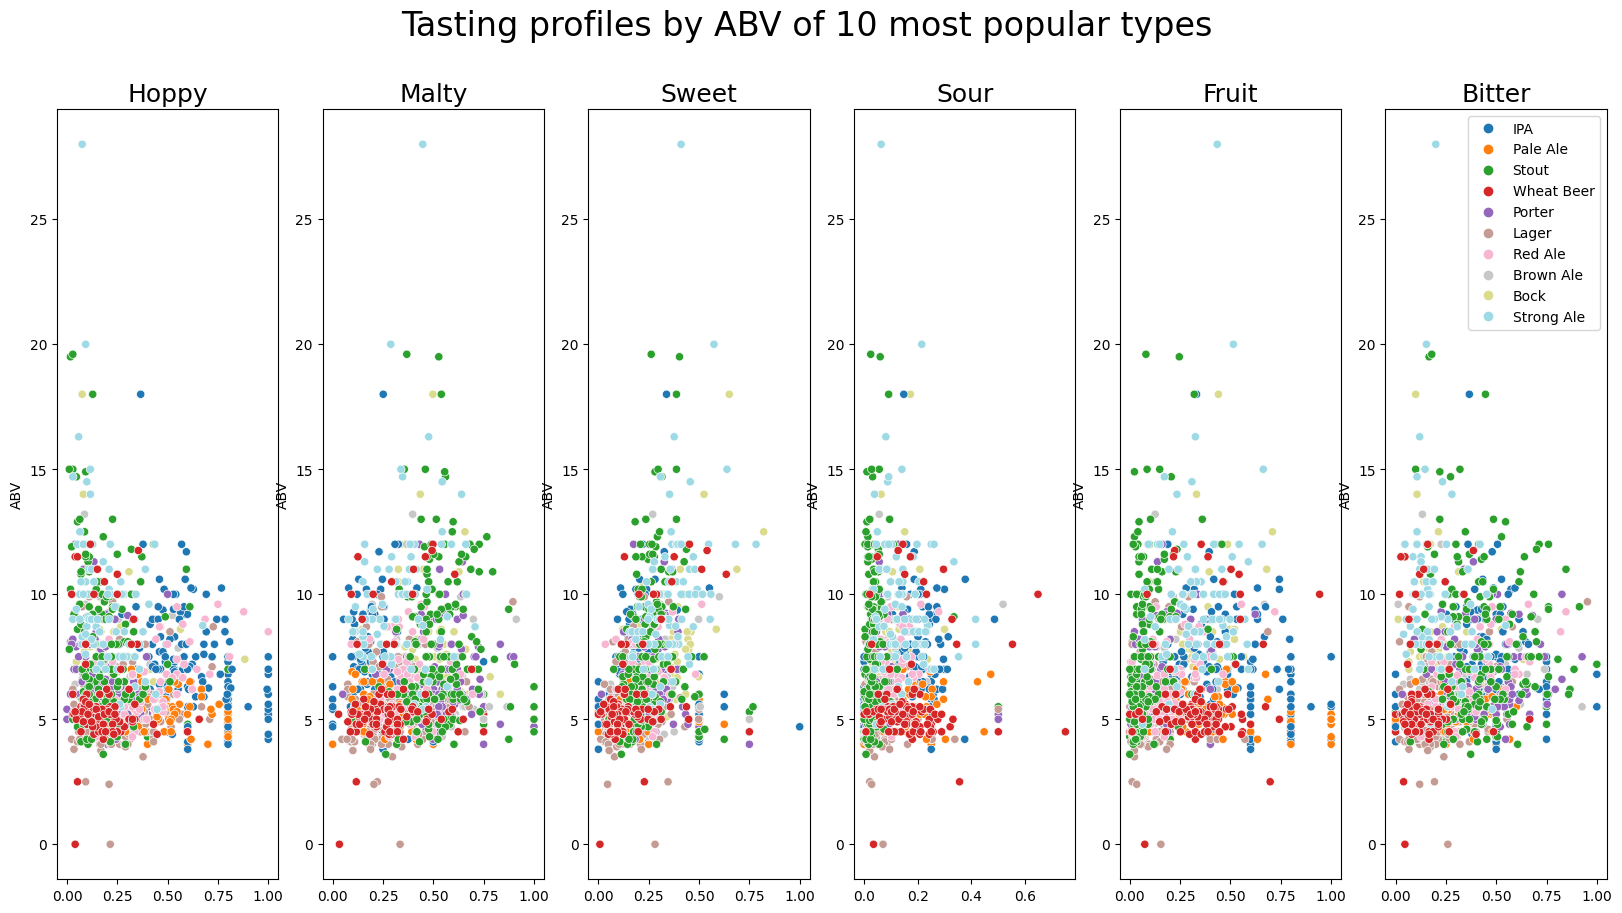

In [26]:
fig, ax = plt.subplots(1, 6, figsize=(20, 10))

subplots = [a for a in ax]
tastes = ['Hoppy', 'Malty', 'Sweet','Sour','Fruit','Bitter']
colors = sorted_colors

for taste, subplot, color in zip(tastes, subplots, colors):
    sns.scatterplot(x = tastes_to_plot[taste], y = tastes_to_plot['ABV'], ax=subplot, color=sorted_colors)
    subplot.set_title(taste, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Tasting profiles by ABV of 10 most popular types', fontsize=24)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors_dict.values()]
plt.legend(markers, colors_dict, numpoints=1,loc='upper right',ncol=1)

plt.show()

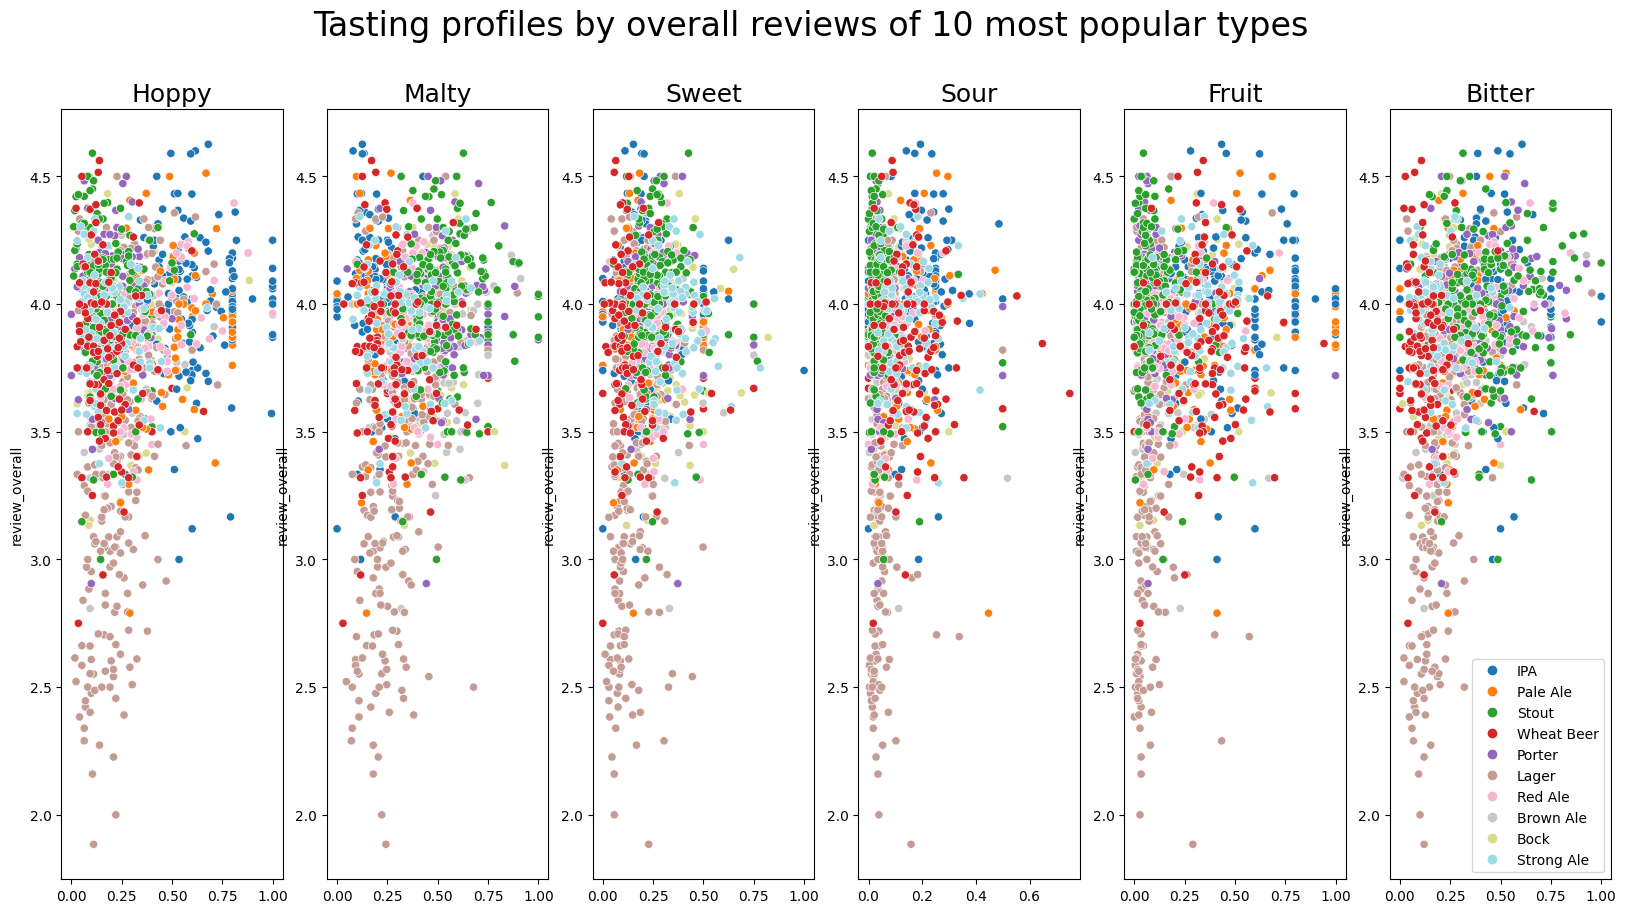

In [27]:
fig, ax = plt.subplots(1, 6, figsize=(20, 10))

subplots = [a for a in ax]
tastes = ['Hoppy', 'Malty', 'Sweet','Sour','Fruit','Bitter']
colors = list(sns.husl_palette(10, h=.5)[1:7]) 

for taste, subplot, color in zip(tastes, subplots, colors):
    sns.scatterplot(x = tastes_to_plot[taste], y = data['review_overall'], ax=subplot, color=sorted_colors)
    subplot.set_title(taste, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Tasting profiles by overall reviews of 10 most popular types', fontsize=24)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors_dict.values()]
plt.legend(markers, colors_dict, numpoints=1,loc='lower right',ncol=1)

plt.show()

### Preparing words for processing

In [28]:
notes = data['Description']
notes_list = [note for note in notes]
big_note_string = ' '.join(notes_list)

In [29]:
additional_stop_words=['albeit','style','type','name','ABV','brewed','centrifuged','part','creating','typical','also','across','idaho','finnish','american','malted','underpin','strip','nods','kettle','whirlpool','fermented','hops','ensure','showcasing','displaying','got','hop','centennial','made','years','coming','beer','really','caryy','lucky','developed','lager','drinks,''made','recent','special','double', 'ipa', 'tasting', 'brewery', 'notes','beers', 'special','flavours', 'hull','research','institute', 'Hazy IPA', 'American pale ale', 'Session IPA', 'Pilsner',
       'Pale ale', 'gola', 'british', 'german','bring','us','brewery','come','match','contains','develops','bill','backed','abv','makes','finishes,''secca','base','note','notes','dropped','von','Foreign extra stout', 'Italian dry stout','Pastry stout', 'Berlin stout', 'Kölsch', 'West Coast pale ale',
       'West Coast IPA', 'munich','designed','built','first','keep','underscored','porter', 'mostly','every','each','lagered','bag','bags','character','characters','giving','way',
       'inspired','by','although','house','tastes','plus','anything','finishes','represents','belgium','Double IPA', 'Wheat Beer - Witbier','New England IPA', 'New Zealand IPA', 'Porter',
       'Espresso milk stout', 'Coffee stout', 'Stout', 'Mango sour','Hefeweizen', 'Limoncello blonde', 'Hazy pale ale',
       'Mango pale ale', 'IPA', 'Modern pale ale', 'Session pastry stout','Black IPA', 'American wheat beer', 'West Coast Session IPA',
       'Sour', 'Helles', 'Wheat ale', 'Milkshake IPA', 'Lager','NE pale ale', 'DDH pale ale', 'NZ session IPA',
       'Gluten free session IPA', 'Robust porter','Tropical foreign extra stout', 'Rye ale', 'Marzen',
       'Contemporary IPA', 'Grapefruit IPA', 'Munich Helles lager','Cold IPA', 'Traditional red ale', 'Brown ale', 'Milk stout',
       'Nitro sout', 'Watermelon IPA', 'Altbier', 'Barleywine - American','Barleywine - English',
       'Bitter - English Extra Special / Strong Bitter (ESB)','Bitter - English', 'Bière de Champagne / Bière Brut',
       'Blonde Ale - American', 'Blonde Ale - Belgian','Bock - Doppelbock', 'Bock - Eisbock', 'Bock - Maibock','Bock - Traditional', 'Bock - Weizenbock', 'Braggot', 'Brett Beer',
       'Brown Ale - American', 'Brown Ale - Belgian Dark','Brown Ale - English', 'California Common / Steam Beer',
       'Chile Beer', 'Cream Ale', 'Dubbel','Farmhouse Ale - Bière de Garde', 'Farmhouse Ale - Sahti',
       'Farmhouse Ale - Saison', 'Fruit and Field Beer','Gruit / Ancient Herbed Ale', 'Herb and Spice Beer','IPA - American', 'IPA - Belgian', 'IPA - English',
       'IPA - Imperial', 'Kvass', 'Lager - Adjunct','Lager - American Amber / Red', 'Lager - American',
       'Lager - European / Dortmunder Export', 'Lager - European Dark','Lager - European Pale', 'Lager - European Strong',
       'Lager - Helles', 'Lager - India Pale Lager (IPL)','Lager - Japanese Rice', 'Lager - Kellerbier / Zwickelbier',
       'Lager - Light', 'Lager - Malt Liquor', 'Lager - Munich Dunkel','Lager - Märzen / Oktoberfest', 'Lager - Rauchbier',
       'Lager - Schwarzbier', 'Lager - Vienna', 'Lambic - Faro','Lambic - Fruit', 'Lambic - Gueuze', 'Lambic - Traditional',
       'Low Alcohol Beer', 'Mild Ale - English Dark','Mild Ale - English Pale', 'Old Ale', 'Pale Ale - Belgian',
       'Pale Ale - English', 'Pilsner - Bohemian / Czech','Pilsner - German', 'Pilsner - Imperial', 'Porter - American',
       'Porter - Baltic', 'Porter - English', 'Porter - Imperial','Porter - Robust', 'Porter - Smoked', 'Pumpkin Beer',
       'Quadrupel (Quad)', 'Red Ale - American Amber / Red','Red Ale - Imperial', 'Red Ale - Irish', 'Rye Beer - Roggenbier',
       'Rye Beer', 'Scotch Ale / Wee Heavy', 'Scottish Ale','Smoked Beer', 'Sour - Berliner Weisse',
       'Sour - Flanders Oud Bruin', 'Sour - Flanders Red Ale','Sour - Gose', 'Stout - American Imperial', 'Stout - American',
       'Stout - English', 'Stout - Foreign / Export', 'Stout - Irish Dry','Stout - Oatmeal', 'Stout - Russian Imperial',
       'Stout - Sweet / Milk', 'Strong Ale - American','Strong Ale - Belgian Dark', 'Strong Ale - Belgian Pale',
       'Strong Ale - English', 'Tripel', 'Wheat Beer - American Dark','Wheat Beer - American Pale', 'Wheat Beer - Dunkelweizen',
       'Wheat Beer - Kristallweizen', 'Wheat Beer - Wheatwine','Wild Ale', 'Winter Warmer','IPA', 'Pale Ale', 'Pilsner', 'Stout', 'Kölsch', 'Wheat Beer',
       'Porter', 'Sour', 'Blonde', 'Black IPA', 'Helles', 'Lager','Rye Beer', 'Marzen', 'Red Ale', 'Brown ale', 'Altbier',
       'Barleywine', 'Bitter', 'Bière de Champagne / Bière Brut', 'Bock','Braggot', 'Brett Beer', 'Brown Ale',
       'California Common / Steam Beer', 'Chile Beer', 'Cream Ale','Dubbel', 'Farmhouse Ale', 'Fruit and Field Beer',
       'Herb and Spice Beer', 'Kvass', 'Lambic', 'Low Alcohol Beer','Mild Ale', 'Old Ale', 'Pumpkin Beer', 'Quadrupel (Quad)',
       'Scottish Ale', 'Smoked Beer', 'Strong Ale']

In [30]:
tokens = word_tokenize(big_note_string)

words = [word.lower() for word in tokens if word.isalpha()]

nltk_stop_words = list(stopwords.words('english'))

stop_words=nltk_stop_words+additional_stop_words

words = [word for word in words if not word in stop_words]

In [31]:
words[:10]

['exotic',
 'spicy',
 'mango',
 'pineapple',
 'notable',
 'tangering',
 'watermelon',
 'gentle',
 'malts',
 'luscious']

In [33]:
wv = api.load('word2vec-google-news-300')

In [34]:
vector_list = [wv[word] for word in words if word in wv.key_to_index]

words_filtered = [word for word in words if word in wv.key_to_index]

word_vec_zip = zip(words_filtered, vector_list)

word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
exotic,0.02185,0.07178,-0.11377,0.16992,-0.10791,-0.02173,0.15234,-0.06494,-0.25391,0.24707,0.16699,-0.38477,-0.08936,-0.12891,-0.16211,0.20898,-0.07617,0.20801,0.22852,0.17871,-0.10059,-0.12598,-0.01575,-0.09766,-0.12891,0.01941,-0.12305,0.14941,0.04175,-0.11084,-0.09473,0.13184,0.13477,0.21973,-0.10205,-0.21875,0.04321,-0.36719,-0.00681,-0.01624,0.23047,-0.31836,-0.16992,0.27148,-0.22461,-0.35938,0.02625,0.29883,0.15234,-0.10693,...,0.00897,0.10791,0.31641,-0.10986,0.03784,-0.19727,-0.17773,-0.18262,0.14062,0.00812,0.10254,-0.05176,0.01428,-0.04541,0.06152,-0.07520,-0.29297,-0.24609,-0.07373,-0.11670,-0.00034,0.15137,0.02673,0.06177,0.15234,-0.13086,0.05933,-0.04395,-0.13672,0.07324,0.01636,-0.09180,-0.16113,-0.37109,-0.10010,0.28320,-0.16016,-0.11328,-0.03223,0.06885,-0.14941,0.06787,0.01648,0.18457,-0.02747,0.16211,0.10254,-0.01733,0.10449,-0.02673
spicy,-0.21875,-0.05688,0.23242,0.19434,0.00108,0.00983,0.15137,-0.01044,-0.19434,0.42383,-0.07422,-0.36133,0.08691,0.02344,-0.16992,0.33984,-0.16797,-0.03979,0.11230,-0.18750,0.02649,0.06787,0.29492,-0.19434,-0.09814,-0.50391,0.08447,0.04590,-0.07715,0.13574,0.02307,0.24805,0.19238,-0.04053,-0.16211,-0.17285,0.26367,-0.08398,0.00055,0.26758,-0.05615,-0.46875,0.20996,0.25586,-0.11719,-0.60938,-0.18848,-0.14453,0.06128,0.11182,...,0.17188,0.14941,0.41211,0.04736,0.17383,-0.38281,-0.18555,-0.16211,0.11768,-0.12354,0.19434,0.37305,-0.07715,-0.17188,0.11377,-0.19727,-0.16797,-0.12158,0.07715,-0.16016,0.03711,-0.06299,-0.07373,0.04248,0.40430,0.00699,-0.06445,-0.12207,-0.21484,-0.07080,0.19238,-0.01117,-0.23633,0.04199,0.08350,-0.24609,-0.07422,-0.05908,-0.28516,0.11035,0.21875,-0.20703,0.10449,0.28320,0.40234,-0.09668,0.19531,-0.13184,-0.00546,0.20508
mango,-0.27148,0.09229,0.08789,0.23926,0.00897,0.13672,0.05981,-0.25391,-0.12500,0.16211,0.15918,-0.16504,-0.06836,0.19629,-0.16406,0.22266,-0.10938,-0.02612,-0.22461,0.13672,-0.24805,0.01099,0.11719,-0.07080,0.03149,-0.10107,-0.06396,0.05737,-0.02307,0.11084,-0.22266,-0.09375,-0.09277,0.14551,-0.22949,-0.04614,-0.15039,-0.33008,0.20508,-0.13770,-0.01807,-0.07617,-0.05859,0.24609,-0.24219,-0.31641,-0.15723,-0.10059,0.13281,0.15820,...,-0.12500,-0.13672,0.44922,-0.23438,0.16113,-0.29297,-0.03369,-0.06006,-0.18066,-0.28320,0.16797,0.30664,-0.17188,0.01141,0.06982,-0.32617,-0.26953,0.31836,-0.14453,-0.31250,-0.16016,0.14062,0.00879,-0.09717,0.21777,0.19336,-0.10889,-0.03564,-0.21191,0.15820,-0.08984,0.06104,0.07178,-0.24902,0.21973,-0.25391,-0.18945,-0.01648,-0.23047,0.33008,-0.30469,-0.27344,0.14355,-0.34570,0.11865,0.10303,0.00130,0.11621,0.19922,0.24121


In [35]:
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
tsne_df = tsne.fit_transform(df[:1000])

/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


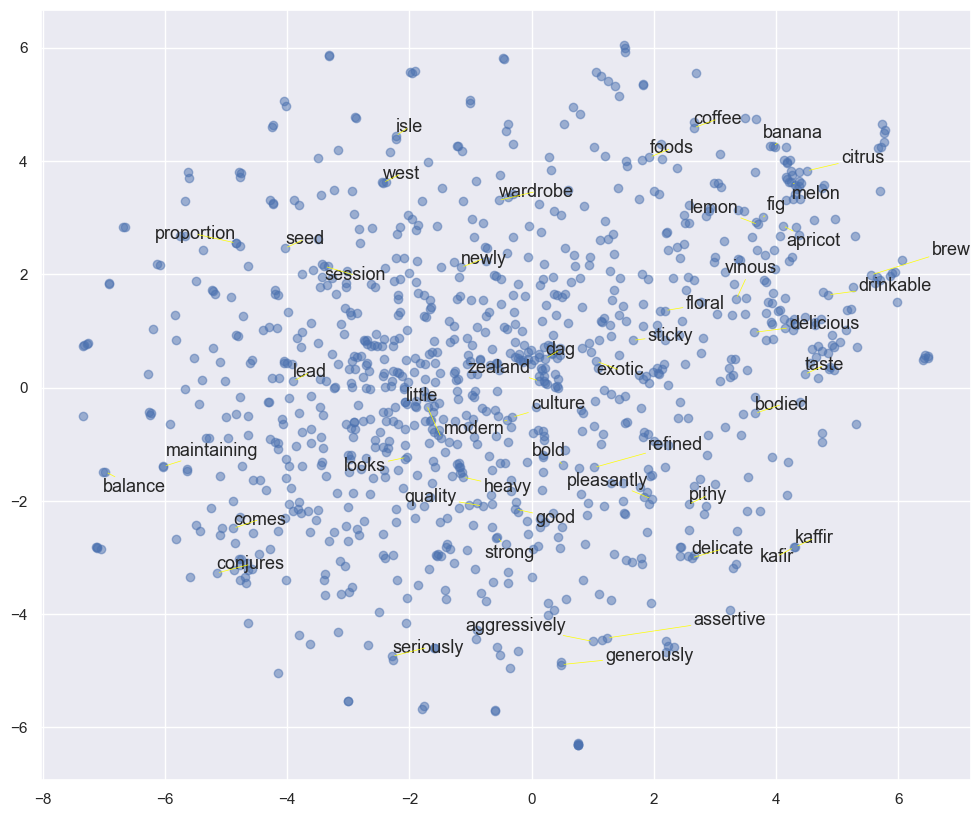

In [36]:
sns.set()

fig, ax = plt.subplots(figsize = (12,10))
plt.scatter(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

texts = []
words_to_plot = list(np.arange(0, 500, 10))

for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 13))
    
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'yellow', lw = 0.5))

plt.show()

In [37]:
def document_vector(wv, doc):
    doc = [word for word in doc if word in wv.key_to_index]
    return np.mean(wv[doc], axis=0)

def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

def has_vector_representation(wv, doc):
    return not all(word not in wv.key_to_index for word in doc)

def filter_docs(corpus, texts, condition_on_doc):
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [39]:
corpus = [preprocess(note) for note in notes_list]

corpus, notes_list = filter_docs(corpus, notes_list, lambda doc: has_vector_representation(wv, doc))

corpus, notes_list = filter_docs(corpus, notes_list, lambda doc: (len(doc) != 0))
x = []
for doc in corpus:
    x.append(document_vector(wv, doc))
    
X = np.array(x)

0 docs removed
0 docs removed


In [40]:
pca = PCA(n_components=10, random_state=10)

reduced_vecs = pca.fit_transform(X)
df_w_vectors = pd.DataFrame(reduced_vecs)

main_w_vectors = pd.concat((df_w_vectors, data), axis=1)
main_w_vectors.dropna(axis=0, inplace=True)

/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


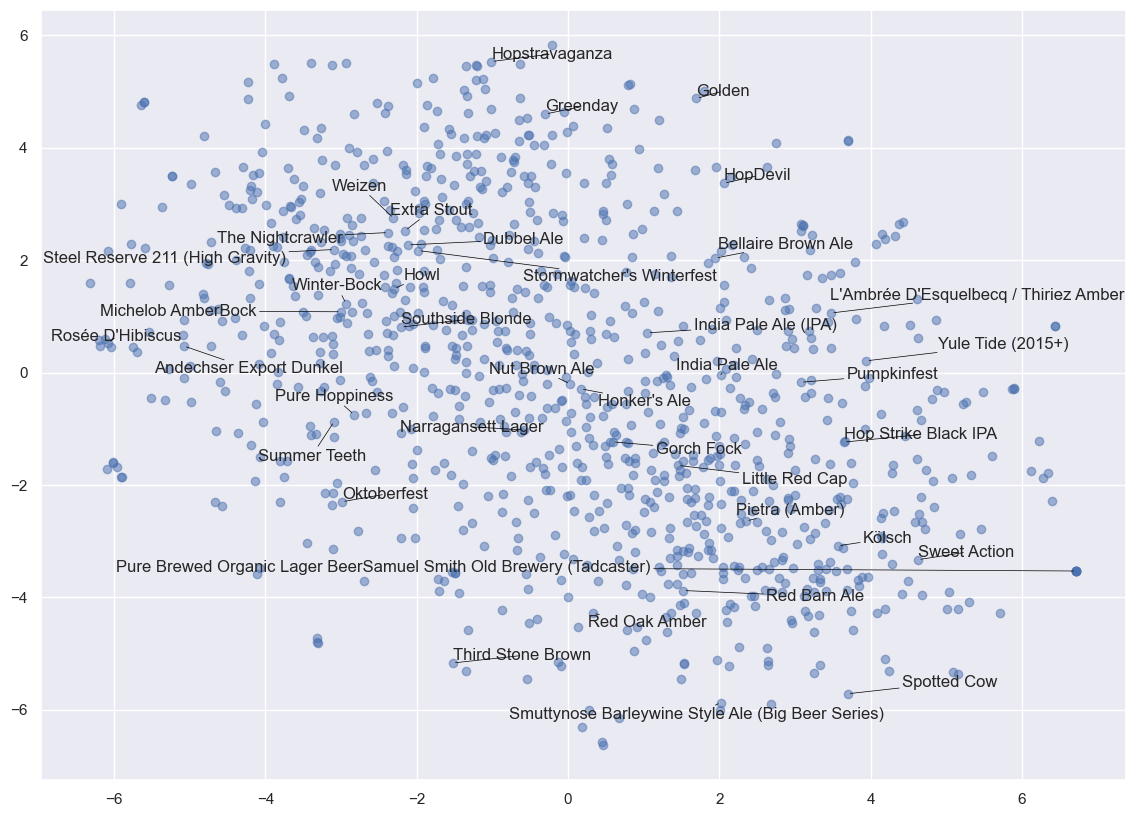

In [41]:
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

tsne_df = tsne.fit_transform(X[:1000])
fig, ax = plt.subplots(figsize = (14, 10))
plt.scatter(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

texts = []
notes_to_plot = list(np.arange(0, 1000, 25))

for i in notes_to_plot:
    texts.append(plt.text(tsne_df[i, 0], tsne_df[i, 1], data["Name"][i], fontsize = 12))
    
adjust_text(texts, force_points = 0.4, force_text = 0.6, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

In [42]:
vectors=main_w_vectors.drop(columns=['Type','Name','Brewery','Style','ABV','Description','review_overall','number_of_reviews'])

In [43]:
X = vectors.drop(columns=['Hoppy','Malty','Sweet','Sour','Fruit','Bitter'], axis=1)
y = vectors[['Hoppy','Malty','Sweet','Sour','Fruit','Bitter']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [44]:
xgr = xgb.XGBRegressor(random_state=2)

xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

0.0373447959435143

In [45]:
for feature, importance in zip(list(X.columns), xgr.feature_importances_):
    print('Model weight for feature {}: {}'.format(feature, importance))

Model weight for feature 0: 0.05426417663693428
Model weight for feature 1: 0.08374029397964478
Model weight for feature 2: 0.09165115654468536
Model weight for feature 3: 0.10150586068630219
Model weight for feature 4: 0.1052636057138443
Model weight for feature 5: 0.09450408816337585
Model weight for feature 6: 0.1051211729645729
Model weight for feature 7: 0.1286177784204483
Model weight for feature 8: 0.1282094120979309
Model weight for feature 9: 0.1071225181221962


### Making predictions

In [47]:
gbbf=pd.read_csv("./gbbf.csv")
gbbf=gbbf.drop(["web-scraper-order", "web-scraper-start-url"], axis = 1)

gbbf["name"] = gbbf["name"].str.replace("\t","")
gbbf["name"] = gbbf["name"].str.replace("\n","")

gbbf["Beer_name"]=gbbf["name"].str.extract('-(.*?)-', expand=False).str.strip()

gbbf["Brewery"]=gbbf["name"].str.extract('(.*?)-', expand=False).str.strip()
gbbf["Brewery"]=gbbf["Brewery"].str.replace("-","")

gbbf["Style"]=gbbf["name"].str.extract('%-(.*?)B\d\d', expand=False).str.strip()

gbbf["ABV"]=gbbf["name"].str.extract('(\d+\.*\d*%)', expand=False).str.strip()

gbbf["Description"]=gbbf["name"].str.extract('B\d\d(.*)', expand=False).str.strip()

gbbf=gbbf.drop(["name"],axis=1)
gbbf=gbbf.rename(columns={'Beer_name':'Name'})

gbbf=gbbf[gbbf["Description"]!='Tasting notes coming soon ...']
gbbf=gbbf[gbbf["Description"]!='Tasting notes not available']

gbbf

,Name,Brewery,Style,ABV,Description
0,Cascade,Burton Town,IPA,5.6%,Our American West Coast style IPA packed full ...
1,Shark Island Stout,Bridgetown,Stout,4.5%,"Dark bitter grain, deep finish with coffee, a ..."
4,Blackheath Stout,Fixed Wheel,Stout,5%,Full Bodied fruity stout dedicated to the home...
5,Steam Stout,Steam Town,Stout,4.5%,Milk stout with complex chocolate malt bittern...
6,Bumble,Bowland,Blonde,4%,Blonde Ale lightly hopped with double addition...
...,...,...,...,...,...
706,Squirrel's Heaven,4Ts,Stout,4.8%,"Peanut butter stout, nutty and smooth"
707,Dark Horse,Struise Brouwers (Belgium),Other,7%,"Hybrid of earthmonk & dirty horse, aged for 4 ..."
708,Arkells 3B,Arkells,Bitter,4%,Originally known as Arkells Best Bitter Beer. ...
709,Tom Paine Ale,Harveys,Bitter,5.5%,Tom Paine is a premium dry hopped bitter named...


In [48]:
n=gbbf.loc[5]['Description']

In [49]:
new_df = data.append({'Description':n}, ignore_index=True)

notes = new_df['Description']
notes_list = [note for note in notes]
big_note_string = ' '.join(notes_list)

tokens = word_tokenize(big_note_string)

words = [word.lower() for word in tokens if word.isalpha()]

nltk_stop_words = list(stopwords.words('english'))

stop_words=nltk_stop_words+additional_stop_words

words = [word for word in words if not word in stop_words]

corpus = [preprocess(note) for note in notes_list]

corpus, notes_list = filter_docs(corpus, notes_list, lambda doc: has_vector_representation(wv, doc))

corpus, notes_list = filter_docs(corpus, notes_list, lambda doc: (len(doc) != 0))
x = []
for doc in corpus:
    x.append(document_vector(wv, doc))
    
X = np.array(x)

pca = PCA(n_components=10, random_state=10)

reduced_vecs = pca.fit_transform(X)
df_w_vectors = pd.DataFrame(reduced_vecs)

main_w_vectors = pd.concat((df_w_vectors, data), axis=1)
main_w_vectors.dropna(axis=0, inplace=True)

vectors=main_w_vectors.drop(columns=['Type','Name','Brewery','Style','ABV','Description','review_overall','number_of_reviews'])

/var/folders/zm/dhzc6hfd3qd47z4csx3yvn3m0000gn/T/ipykernel_32010/2975800370.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = data.append({'Description':n}, ignore_index=True)


33 docs removed
0 docs removed


In [50]:
new_vector=pd.DataFrame(vectors.iloc[-1][0:10]).T
p=xgr.predict(new_vector)
p

array([[0.15158485, 0.36934578, 0.29134554, 0.11726993, 0.11452308,
        0.12578292]], dtype=float32)

In [51]:
taste_df=data[['Hoppy', 'Malty', 'Sweet', 'Sour','Fruit', 'Bitter']]

In [52]:
taste_df = taste_df.append({'Hoppy':p[0][0], 'Malty':p[0][1], 'Sweet':p[0][2], 'Sour':p[0][3], 
                            'Fruit':p[0][4], 'Bitter':p[0][5]}, ignore_index=True)

simsMatrix = cosine(taste_df)
similarities = pd.DataFrame(simsMatrix, index = taste_df.index, columns = taste_df.index)

top_10=similarities[1955].sort_values(ascending=False)[:10]

inds=top_10.index[1:11]

taste_df=taste_df.drop(1955)

data.iloc[inds,:]

/var/folders/zm/dhzc6hfd3qd47z4csx3yvn3m0000gn/T/ipykernel_32010/3198361373.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  taste_df = taste_df.append({'Hoppy':p[0][0], 'Malty':p[0][1], 'Sweet':p[0][2], 'Sour':p[0][3],


,Name,Brewery,Style,ABV,Hoppy,Malty,Sweet,Sour,Fruit,Bitter,Description,review_overall,number_of_reviews,Type
880,Hurricane Malt Liquor,Anheuser-Busch,Lager - Malt Liquor,5.90000,0.09302,0.25941,0.18631,0.07394,0.08571,0.08000,Hurricane Malt Liquor is full-bodied and robus...,2.40141,71,Lager
1436,Louie's Reserve Scotch Ale,Lake Louie Brewery Company,Scotch Ale / Wee Heavy,10.00000,0.22674,0.54393,0.39544,0.11620,0.18857,0.22000,Released annually in August\t,4.16667,84,Scottish Ale
417,Hot-Jala-Heim,Horseheads Brewing Inc.,Chile Beer,7.20000,0.06395,0.17573,0.12548,0.04930,0.07429,0.06667,"This style of beer is classified in the ""Fruit...",3.66667,39,Chile Beer
274,Emancipator Doppelbock,Christian Moerlein Brewing Company,Bock - Doppelbock,7.00000,0.20349,0.53556,0.39544,0.09507,0.18286,0.15333,Christian Moerlein Doppelbock is brewed in acc...,3.72500,20,Bock
440,Canyon Cream Ale,Crow Peak Brewing,Cream Ale,5.00000,0.13372,0.29707,0.21293,0.05634,0.07429,0.11333,A light bodied ale with malty dominated flavor...,3.66667,3,Cream Ale
941,Deep Purple Rauchbier,Marshall Wharf Brewing Company / Three Tides R...,Lager - Rauchbier,6.20000,0.02907,0.07531,0.06084,0.02113,0.03429,0.02000,Smoke on the water! This Bamberg inspired smok...,3.33333,6,Lager
1823,Canebrake,Parish Brewing Company,Wheat Beer - American Pale,5.50000,0.14535,0.39749,0.35741,0.08803,0.16000,0.12667,Canebrake is crisp and smooth with a beautiful...,4.00000,4,Wheat Beer
718,Miller Genuine Draft,Miller Brewing Co.,Lager - Adjunct,4.66000,0.05233,0.14644,0.08745,0.03873,0.04571,0.04667,Miller Genuine Draft delivers a fresh from the...,2.66227,607,Lager
1446,Laughing Lab Scottish-Style Ale,Bristol Brewing Company,Scottish Ale,5.30000,0.16860,0.57322,0.39163,0.09859,0.14286,0.18000,Laughing Lab is our most popular brew among be...,3.77381,84,Scottish Ale
